## Separate inversion of the two synthetic AEM data

In [1]:
import dill 
import numpy as np
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps
from SimPEG.electromagnetics.utils.em1d_utils import get_2d_mesh, get_vertical_discretization
from pymatsolver import PardisoSolver


aem_data_dict = dill.load(open("synthetic_aem_data.pik", "rb"))
source_locations = aem_data_dict['source_locations']
receiver_locations = aem_data_dict['receiver_locations']
topo = aem_data_dict['topo']
times = aem_data_dict['times']
dobs_1 = aem_data_dict['data_1']
dobs_2 = aem_data_dict['data_2']
receiver_orientation = "z"                    # "x", "y" or "z"
source_list = []
n_sounding = topo.shape[0]


for i_sounding in range(n_sounding):    
    source_location = source_locations[i_sounding,:]
    receiver_location = receiver_locations[i_sounding,:]

    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_location, times, orientation=receiver_orientation
        )
    ]

    # General Waveform
    source_list.append(
        tdem.sources.MagDipole(
            receiver_list=receiver_list, location=source_location,
            waveform=tdem.sources.StepOffWaveform(), orientation='z',
            i_sounding=i_sounding
        ),
    )

# Survey
survey = tdem.Survey(source_list)

>> Use cython version


In [2]:
hz = get_vertical_discretization(30, 3, 1.07)

>> Depth from the surface to the base of the bottom layer is 283.4m


In [3]:
survey = tdem.Survey(source_list)
thicknesses = hz[:-1]
mesh = get_2d_mesh(n_sounding, hz)
sigma_map = maps.ExpMap(mesh)

simulation = tdem.Simulation1DLayeredStitched(
    survey=survey, thicknesses=thicknesses, sigmaMap=sigma_map,
    topo=topo, parallel=True, n_cpu=4, verbose=False, solver=PardisoSolver
)

>> Use multiprocessing for parallelization
>> n_cpu: 4


In [4]:
topo.shape

(91, 3)

In [5]:
import matplotlib.pyplot as plt

In [6]:
from SimPEG.electromagnetics.utils.em1d_utils import set_mesh_1d
import scipy as sp
from discretize import SimplexMesh
tmp = topo[:,:2]+np.random.randn(topo[:,:2].shape[0], topo[:,:2].shape[1])
tri = sp.spatial.Delaunay(tmp) 
mesh_radial = SimplexMesh(tri.points, tri.simplices)
mesh_vertical = set_mesh_1d(hz)
mesh_reg = [mesh_radial, mesh_vertical]

In [7]:
def get_active_edge_indices_with_distance(mesh_radial, mesh_vertical, maximum_distance=10):
    nz = mesh_vertical.n_cells
    edge_lengths = mesh_radial.edge_lengths
    inds = edge_lengths < maximum_distance
    indActiveEdges = np.tile(inds.reshape([-1,1]), nz).flatten()
    return inds, indActiveEdges

inds, indActiveEdges = get_active_edge_indices_with_distance(
    mesh_radial, mesh_vertical, maximum_distance=150
)
fr = mesh_radial.nodes[mesh_radial._edges[inds,:][:,0],:]
to = mesh_radial.nodes[mesh_radial._edges[inds,:][:,1],:]

(-100.0, 100.0)

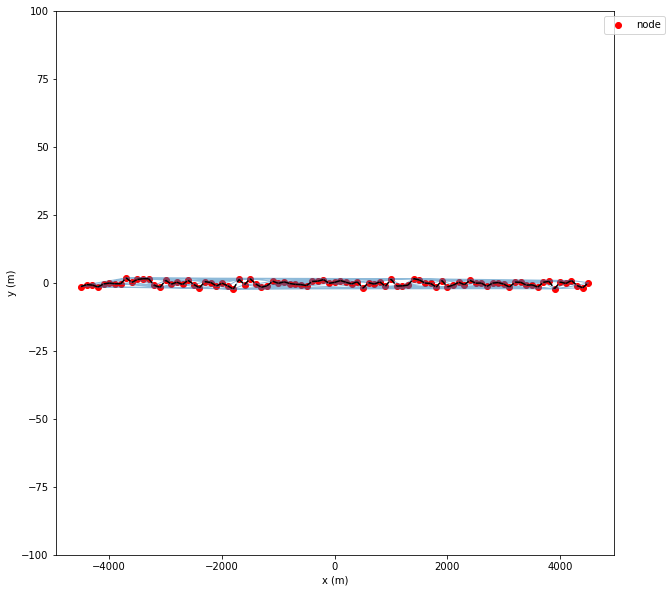

In [8]:
fig = plt.figure(figsize=(10, 10))
plt.plot(mesh_radial.nodes[:,0], mesh_radial.nodes[:,1], 'ro', label='node', zorder=1)
plt.triplot(tmp[:,0], tmp[:,1], tri.simplices[:,:], alpha=0.5, lw=1)

for ii in range(fr.shape[0]):
    plt.plot([fr[ii,0], to[ii,0]], [fr[ii,1], to[ii,1]], 'k--')

plt.legend(bbox_to_anchor=(1.1,1))
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.ylim(-100, 100)
# plt.gca().set_aspect(1)

In [75]:
from SimPEG import (
    maps, data, data_misfit, inverse_problem, regularization, optimization,
    directives, inversion, utils
)
nP = mesh.n_cells
data_object = data.Data(survey, dobs=dobs_1)
uncertainties = abs(dobs_1) * 0.03
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1./uncertainties

regmap = maps.IdentityMap(nP=nP)

reg = regularization.LaterallyConstrained(
    mesh_reg, 
    mapping=regmap,
    alpha_s = 1e-1,
    alpha_r = 1.,
    alpha_z = 1.,
    indActiveEdges=indActiveEdges
)

opt = optimization.ProjectedGNCG(maxIter=20, maxIterCG=20)
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
beta = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = directives.TargetMisfit(chifact=1.)
save_model = directives.SaveOutputDictEveryIteration()
inv = inversion.BaseInversion(invProb, directiveList=[beta, betaest, target, save_model])
invProb.counter = opt.counter = utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
rho_initial = np.ones(nP) * 20.
m0 = np.log(1./rho_initial)
mest = inv.run(m0)
outdict = save_model.outDict
xc = opt.recall('xc')

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.68e+01  3.95e+05  0.00e+00  3.95e+05    1.17e+04      0              
   1  8.40e+00  1.26e+05  8.60e+02  1.33e+05    9.15e+03      1              
   2  4.20e+00  3.12e+04  1.20e+03  3.62e+04    5.04e+03      1              
   3  2.10e+00  1.12e+04  1.51e+03  1.44e+04    6.38e+03      0   Skip BFGS  
   4  1.05e+00  2.19e+03  1.56e+03  3.82e+03    7.61e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.9471e+04
1 : |xc-x_last| = 5.8

In [59]:
data_object = data.Data(survey, dobs=dobs_2)
uncertainties = abs(dobs_2) * 0.03
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1./uncertainties

regmap = maps.IdentityMap(nP=nP)

reg = regularization.LaterallyConstrained(
    mesh_reg, 
    mapping=regmap,
    alpha_s = 1e-1,
    alpha_r = 1.,
    alpha_z = 1.,
    indActiveEdges=indActiveEdges
)

opt = optimization.ProjectedGNCG(maxIter=20, maxIterCG=20)
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
beta = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = directives.TargetMisfit(chifact=1.)
save_model = directives.SaveOutputDictEveryIteration()
inv = inversion.BaseInversion(invProb, directiveList=[beta, betaest, target, save_model])
invProb.counter = opt.counter = utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
rho_initial = np.ones(nP) * 20.
m0 = np.log(1./rho_initial)
mest_2 = inv.run(m0)
outdict = save_model.outDict
xc = opt.recall('xc')

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.59e+01  4.49e+05  0.00e+00  4.49e+05    1.14e+04      0              
   1  7.94e+00  1.43e+05  1.04e+03  1.51e+05    9.28e+03      1              
   2  3.97e+00  3.43e+04  1.44e+03  4.00e+04    5.11e+03      1              
   3  1.98e+00  1.14e+04  1.81e+03  1.50e+04    6.21e+03      0   Skip BFGS  
   4  9.92e-01  2.49e+03  1.90e+03  4.38e+03    7.53e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 4.4924e+04
1 : |xc-x_last| = 6.3

(<matplotlib.collections.QuadMesh at 0x2b078fd25e0>,
 <AxesSubplot:xlabel='Easting (m)', ylabel='Elevation (m)'>,
 <matplotlib.colorbar.Colorbar at 0x2b078fffe50>)

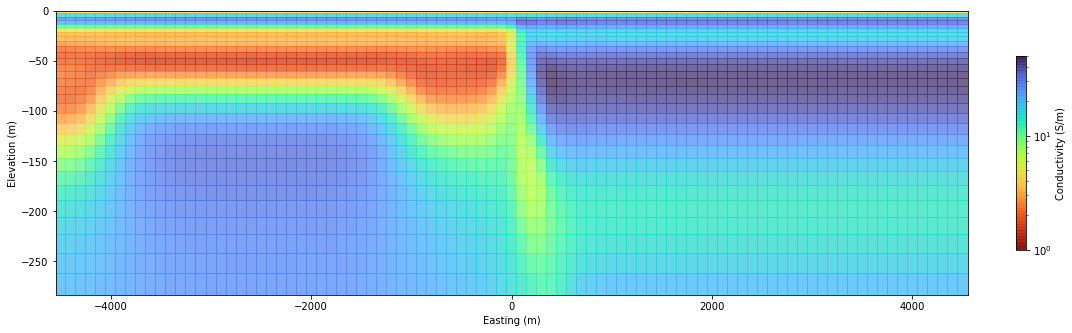

In [92]:
from SimPEG.electromagnetics.utils.em1d_utils import Stitched1DModel
rho_inv = 1./np.exp(mest)
rho_inv_2 = 1./np.exp(mest_2)
model = Stitched1DModel(
    hz=hz[:], 
    line=np.ones(n_sounding), 
    topography=topo,
    time_stamp=np.arange(n_sounding).astype(float), 
    physical_property=rho_inv.reshape((n_sounding, hz.size))[:,:].flatten()
)
model.plot_section(i_line=0, x_axis='x', aspect=10, cmap='turbo_r', clim=(1, 50), dx=50)

(<matplotlib.collections.QuadMesh at 0x2b079c75d90>,
 <AxesSubplot:xlabel='Easting (m)', ylabel='Elevation (m)'>,
 <matplotlib.colorbar.Colorbar at 0x2b079c75d30>)

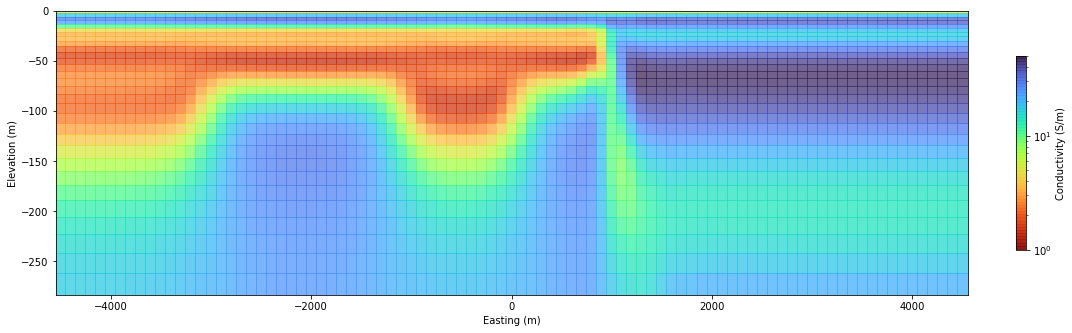

In [93]:
model.plot_section(i_line=0, x_axis='x', aspect=10, cmap='turbo_r', clim=(1, 50), dx=50, physical_property=rho_inv_2)

In [90]:
data_object = data.Data(survey, dobs=dobs_1)
uncertainties = abs(dobs_1) * 0.03
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1./uncertainties

regmap = maps.IdentityMap(nP=nP)

reg = regularization.LaterallyConstrained(
    mesh_reg, 
    mapping=regmap,
    alpha_s = 1e-1,
    alpha_r = 1.,
    alpha_z = 1.,
    indActiveEdges=indActiveEdges,
    gradientType='total'
)

opt = optimization.ProjectedGNCG(maxIter=20, maxIterCG=20)
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
beta = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e-2)
target = directives.TargetMisfit(chifact=1.)
save_model = directives.SaveOutputDictEveryIteration()
p = 2
qr, qz = 0., 0.
reg.norms = np.c_[p, qr, qz, 0.]
irls = directives.Update_IRLS(
    max_irls_iterations=30, minGNiter=1, fix_Jmatrix=False, f_min_change=1e-3
)
inv = inversion.BaseInversion(invProb, directiveList=[betaest, irls, save_model])
invProb.counter = opt.counter = utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
m_lp = inv.run(mest)
outdict = save_model.outDict
xc = opt.recall('xc')

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.06e-01  1.47e+03  8.60e+02  1.73e+03    6.27e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.4639837740847279 eps_q: 0.4639837740847279
   1  1.53e-01  1.09e+03  3.65e+03  1.65e+03    1.10e+03      0              
   2  3.15e-01  8.81e+02  3.15e+03  1.87e+03    3.61e+02      0              
   3  6.49e-01  8.82e+02  2.59e+03  2.56e+03    5.59e+02      0              
   4  1.26e+00  9.86e+02  2.01e+03  3.53e+03    6.17e+02      0              
   5  2.35

In [106]:
data_object = data.Data(survey, dobs=dobs_2)
uncertainties = abs(dobs_2) * 0.03
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1./uncertainties

regmap = maps.IdentityMap(nP=nP)

reg = regularization.LaterallyConstrained(
    mesh_reg, 
    mapping=regmap,
    alpha_s = 1e-1,
    alpha_r = 1.,
    alpha_z = 1.,
    indActiveEdges=indActiveEdges,
    gradientType='total'
)

opt = optimization.ProjectedGNCG(maxIter=30, maxIterCG=30)
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
beta = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e-2)
target = directives.TargetMisfit(chifact=1.)
save_model = directives.SaveOutputDictEveryIteration()
p = 2
qr, qz = 0., 0.
reg.norms = np.c_[p, qr, qz, 0.]
irls = directives.Update_IRLS(
    max_irls_iterations=30, minGNiter=1, fix_Jmatrix=False, f_min_change=1e-3
)
inv = inversion.BaseInversion(invProb, directiveList=[betaest, irls, save_model])
invProb.counter = opt.counter = utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
m_lp_2 = inv.run(mest_2)
outdict = save_model.outDict
xc = opt.recall('xc')

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.17e-01  1.64e+03  9.73e+02  1.95e+03    6.90e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.5997607298351695 eps_q: 0.5997607298351695
   1  1.58e-01  1.20e+03  5.60e+03  2.09e+03    1.52e+03      0              
   2  3.41e-01  8.09e+02  4.66e+03  2.40e+03    4.65e+02      0              
   3  7.10e-01  8.62e+02  3.80e+03  3.56e+03    6.52e+02      0              
   4  1.27e+00  1.19e+03  3.08e+03  5.09e+03    1.10e+03      0              
   5  2.09

(<matplotlib.collections.QuadMesh at 0x2b07b20a970>,
 <AxesSubplot:xlabel='Easting (m)', ylabel='Elevation (m)'>,
 <matplotlib.colorbar.Colorbar at 0x2b07b242220>)

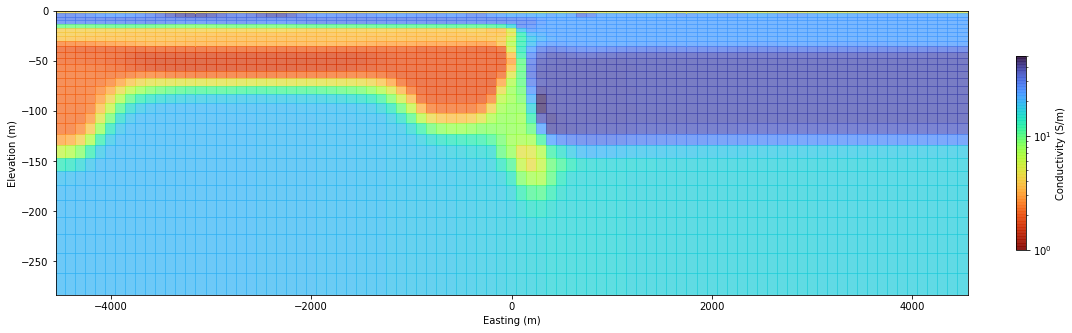

In [108]:
model.plot_section(i_line=0, x_axis='x', aspect=10, cmap='turbo_r', clim=(1, 50), dx=50, physical_property=1./np.exp(m_lp))

(<matplotlib.collections.QuadMesh at 0x2b07ea276d0>,
 <AxesSubplot:xlabel='Easting (m)', ylabel='Elevation (m)'>,
 <matplotlib.colorbar.Colorbar at 0x2b07ea27670>)

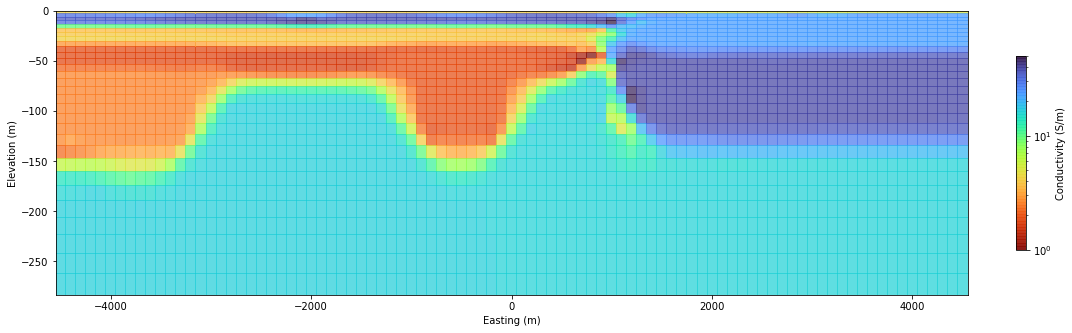

In [112]:
model.plot_section(i_line=0, x_axis='x', aspect=10, cmap='turbo_r', clim=(1, 50), dx=50, physical_property=1./np.exp(m_lp_2))

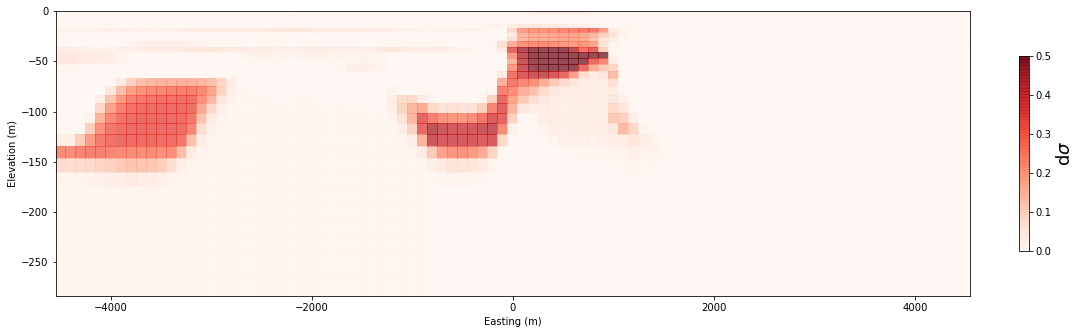

In [124]:
_, ax, cb = model.plot_section(
    i_line=0, x_axis='x', aspect=10, cmap='Reds', dx=50, 
    physical_property=np.exp(m_lp_2)-np.exp(m_lp),
    clim=(0, 0.5),
    scale='linear'
)
cb.set_label("d$\sigma$", fontsize=18)

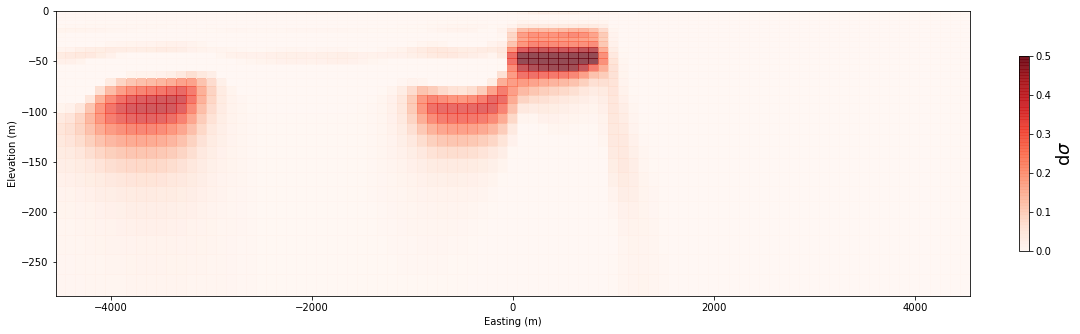

In [126]:
_, ax, cb = model.plot_section(
    i_line=0, x_axis='x', aspect=10, cmap='Reds', dx=50, 
    physical_property=np.exp(mest_2)-np.exp(mest),
    clim=(0, 0.5),
    scale='linear'
)
cb.set_label("d$\sigma$", fontsize=18)

In [130]:
from discretize import TensorMesh
from scipy.interpolate import NearestNDInterpolator

In [129]:
mesh_3d, models_3d = TensorMesh.read_vtk('synthetic_3d_rho.vtr')

In [132]:
f_rho = NearestNDInterpolator(mesh_3d.gridCC, models_3d['rho'])
f_rho_later = NearestNDInterpolator(mesh_3d.gridCC, models_3d['rho_later'])

In [142]:
rho_true = f_rho(model.xyz.reshape((30*91,3),order='F'))
rho_later_true = f_rho_later(model.xyz.reshape((30*91,3),order='F'))

(<matplotlib.collections.QuadMesh at 0x2b000ba6700>,
 <AxesSubplot:xlabel='Easting (m)', ylabel='Elevation (m)'>,
 <matplotlib.colorbar.Colorbar at 0x2b000af7040>)

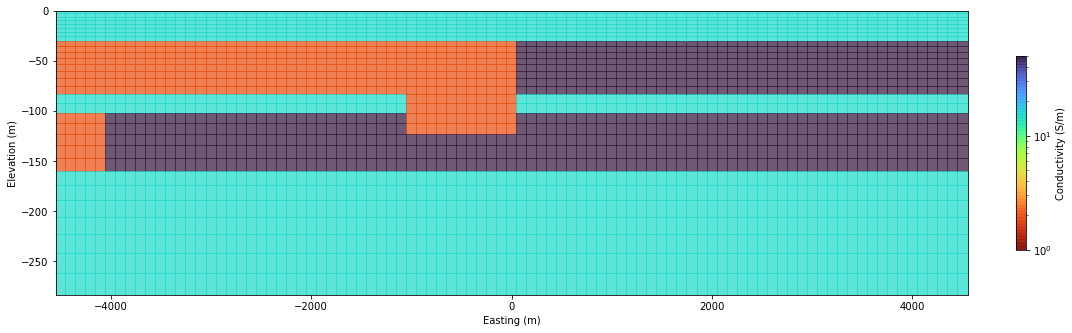

In [143]:
model.plot_section(i_line=0, x_axis='x', aspect=10, cmap='turbo_r', clim=(1, 50), dx=50, physical_property=rho_true)

(<matplotlib.collections.QuadMesh at 0x2b000f47c40>,
 <AxesSubplot:xlabel='Easting (m)', ylabel='Elevation (m)'>,
 <matplotlib.colorbar.Colorbar at 0x2b000f47be0>)

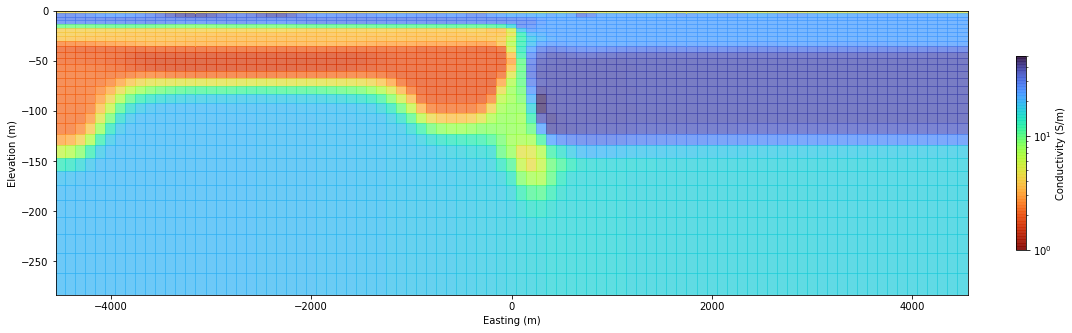

In [144]:
model.plot_section(i_line=0, x_axis='x', aspect=10, cmap='turbo_r', clim=(1, 50), dx=50, physical_property=1./np.exp(m_lp))

(<matplotlib.collections.QuadMesh at 0x2b004d638e0>,
 <AxesSubplot:xlabel='Easting (m)', ylabel='Elevation (m)'>,
 <matplotlib.colorbar.Colorbar at 0x2b004d63880>)

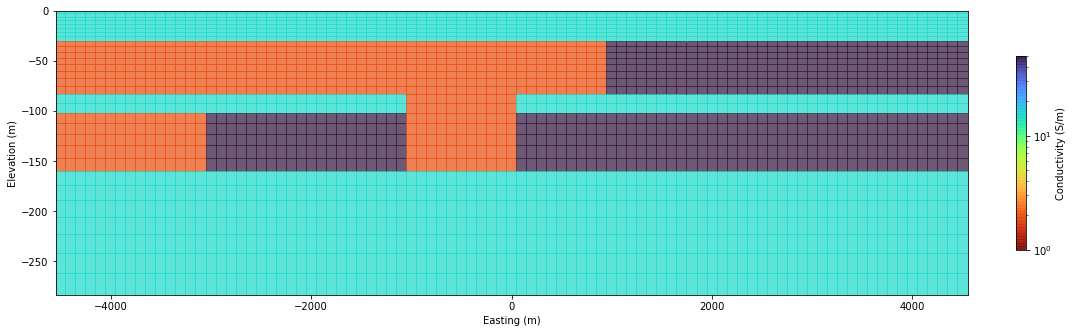

In [146]:
model.plot_section(i_line=0, x_axis='x', aspect=10, cmap='turbo_r', clim=(1, 50), dx=50, physical_property=rho_later_true)

(<matplotlib.collections.QuadMesh at 0x2b0068460d0>,
 <AxesSubplot:xlabel='Easting (m)', ylabel='Elevation (m)'>,
 <matplotlib.colorbar.Colorbar at 0x2b004de3ca0>)

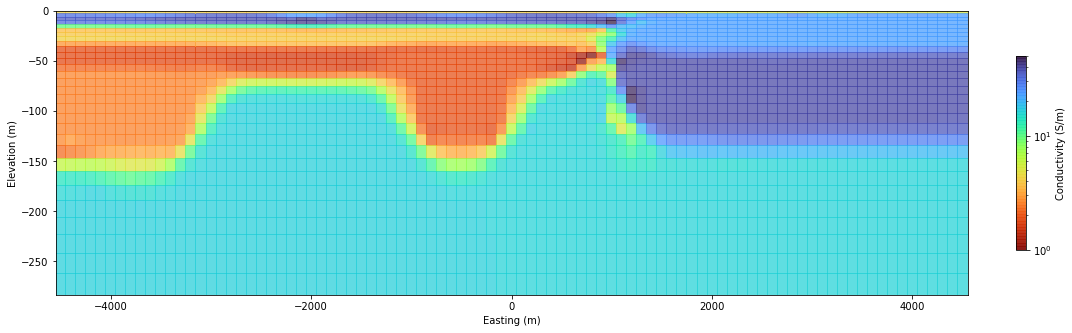

In [147]:
model.plot_section(i_line=0, x_axis='x', aspect=10, cmap='turbo_r', clim=(1, 50), dx=50, physical_property=1./np.exp(m_lp_2))

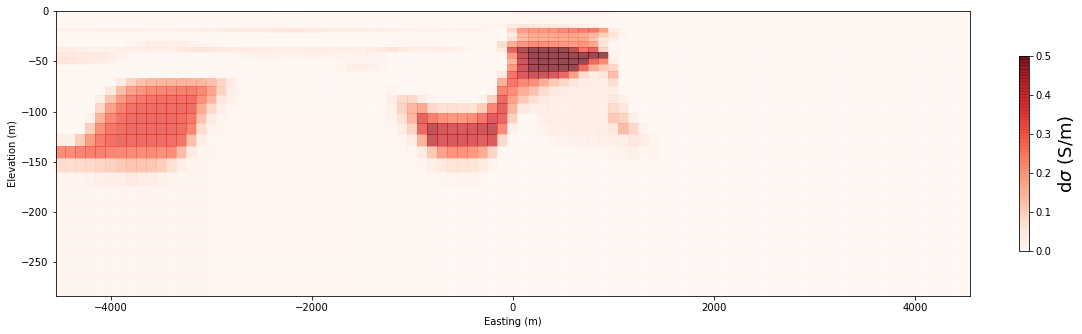

In [150]:
_, ax, cb = model.plot_section(
    i_line=0, x_axis='x', aspect=10, cmap='Reds', dx=50, 
    physical_property=np.exp(m_lp_2)-np.exp(m_lp),
    clim=(0, 0.5),
    scale='linear'
)
cb.set_label("d$\sigma$ (S/m)", fontsize=18)

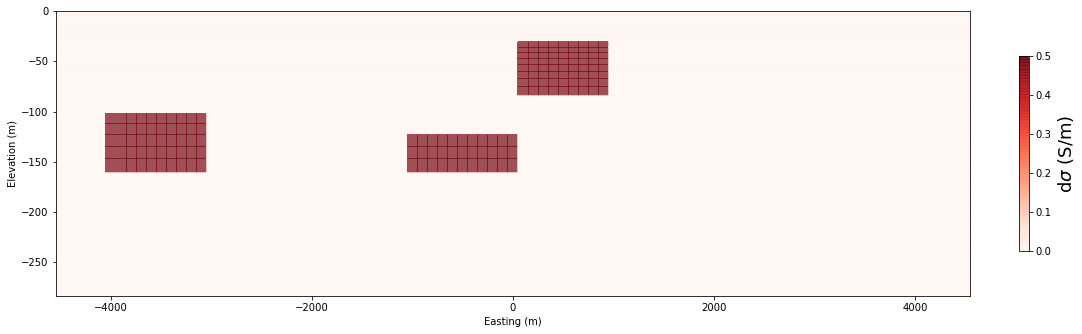

In [151]:
_, ax, cb = model.plot_section(
    i_line=0, x_axis='x', aspect=10, cmap='Reds', dx=50, 
    physical_property=1./rho_later_true-1./rho_true,
    clim=(0, 0.5),
    scale='linear'
)
cb.set_label("d$\sigma$ (S/m)", fontsize=18)

## Targeted inversion of time-lapse airborne electromagnetic data for monitoring saltwater intrusion

- Journal: Geophysics
- XXX
- XXX